In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
import urllib.request
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'
filename = 'housing_hw_data.csv'
urllib.request.urlretrieve(url, filename)
data = pd.read_csv(filename)

In [3]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

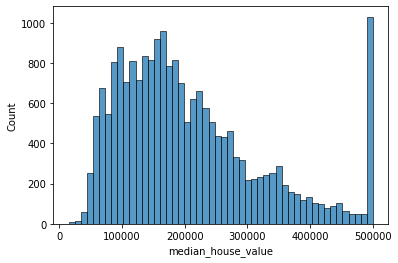

In [4]:
sns.histplot(data.median_house_value, bins= 50)

It does not looks like long tail distribution

In [5]:
hw_features = data.dtypes[data.dtypes != 'O'].index.tolist()
hw_data = data[hw_features]

### Q1 :Find a feature with missing values. How many missing values does it have?

In [6]:
hw_data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

### Q2: What's the median (50% percentile) for variable 'population'?

In [7]:
hw_data.population.median()

1166.0

### Split the data

In [8]:
n =  len(data)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test # because rouding cause lost in data

In [9]:
n, n_val + n_test + n_train #should be same

(20640, 20640)

In [10]:
idx = np.arange(n)
np.random.seed(2)
np.random.shuffle(idx)

In [11]:
n_train

12384

In [12]:
data_train = data.iloc[idx[:n_train]]
data_val = data.iloc[idx[n_train:n_train+n_val]]
data_test = data.iloc[idx[n_train+n_val:]]

data_train = data_train.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [13]:
y_train = np.log1p(data_train.median_house_value.values)
y_val = np.log1p(data_val.median_house_value.values)
y_test = np.log1p(data_test.median_house_value.values)

In [14]:
del data_train["median_house_value"]
del data_val["median_house_value"]
del data_test["median_house_value"]

### Q3

By filling with 0

In [15]:
def prepare_X(df, fill_val):
    df = df.copy()
    
    hw_fea_without_output = [x for x in hw_features if x != "median_house_value"]
    df_num = df[hw_fea_without_output]
    df_num = df_num.fillna(fill_val)
    X = df_num.values
    return X

In [16]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [17]:
def rmse(y, y_pred):
    se = (y-y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [19]:
X_n_train = prepare_X(data_train, 0)
w0_n, w_n = train_linear_regression(X_n_train, y_train)

X_n_val = prepare_X(data_val, 0)
y_n_pred = w0_n + X_n_val.dot(w_n)

np.round(rmse(y_val, y_n_pred),2)

0.33

By filling with mean

In [21]:
mean = data_train.total_bedrooms.mean()

X_mean_train = prepare_X(data_train, mean)
w0_mean, w_mean = train_linear_regression(X_mean_train, y_train)

X_mean_val = prepare_X(data_val, mean)
y_mean_pred = w0_mean + X_mean_val.dot(w_mean)

np.round(rmse(y_val, y_mean_pred),2)

0.33

### Question 4: Which r gives the best RMSE?

In [22]:
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0]) #we add an additional column of ones, since we merge w0 tu our weights vector 
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [24]:
for r in [0.0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:

    #Train part
    w0, w = train_linear_regression_reg(X_n_train, y_train, r=r)
    y_n_reg_val = w0 + X_n_val.dot(w)
    
    rmse_val = np.round(rmse(y_val, y_n_reg_val),2)
    
    print(r, w0, rmse_val)

0.0 -11.806729360745713 0.33
1e-06 -11.806713628182896 0.33
0.0001 -11.805156321789905 0.33
0.001 -11.791017805728968 0.33
0.01 -11.65147278814863 0.33
0.1 -10.418426512930274 0.33
1 -5.060875818182057 0.34
5 -1.5386307850109653 0.34
10 -0.821670832698214 0.34


### Question 5

In [26]:
rmse_list = []

for r in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:

    idx = np.arange(n)
    np.random.seed(r)
    np.random.shuffle(idx)

    data_shuffled = data.iloc[idx]
    
    data_train = data_shuffled.iloc[:n_train].copy()
    data_val = data_shuffled.iloc[n_train:n_train+n_val].copy()
    data_test = data_shuffled.iloc[n_train+n_val:].copy()

    data_train = data_train.reset_index(drop=True)
    data_val = data_val.reset_index(drop=True)
    data_test = data_test.reset_index(drop=True)
    
    y_train = np.log1p(data_train.median_house_value.values)
    y_val = np.log1p(data_val.median_house_value.values)
    y_test = np.log1p(data_test.median_house_value.values)
    
    del data_train['median_house_value']
    del data_val['median_house_value']
    del data_test['median_house_value']
    
    X_n_train = prepare_X(data_train, 0)
    w0_n, w_n = train_linear_regression(X_n_train, y_train)
    
    X_n_val = prepare_X(data_val, 0)
    y_n_reg_val = w0_n + X_n_val.dot(w_n)
    rmse_val = np.round(rmse(y_val, y_n_reg_val),2)
    
    rmse_list.append(rmse_val)
    
    print(r, w0, rmse_val)

0 -0.821670832698214 0.34
1 -0.821670832698214 0.34
2 -0.821670832698214 0.33
3 -0.821670832698214 0.34
4 -0.821670832698214 0.34
5 -0.821670832698214 0.34
6 -0.821670832698214 0.35
7 -0.821670832698214 0.34
8 -0.821670832698214 0.35
9 -0.821670832698214 0.34


In [27]:
rmse_list

[0.34, 0.34, 0.33, 0.34, 0.34, 0.34, 0.35, 0.34, 0.35, 0.34]

In [28]:
np.round(np.std(rmse_list),3)

0.005

### Question 6

In [29]:
idx = np.arange(n)
np.random.seed(r)
np.random.shuffle(idx)

data_shuffled = data.iloc[idx]

data_train= data_shuffled.iloc[:n_train].copy()
data_val = data_shuffled.iloc[n_train:n_train+n_val].copy()
data_test = data_shuffled.iloc[n_train+n_val:].copy()

frames = [data_train, data_val]

data_train_val = pd.concat(frames)

data_train_val = data_train_val.reset_index(drop=True)
data_test =data_test.reset_index(drop=True)

y_train_val = np.log1p(data_train_val.median_house_value.values)
y_test = np.log1p(data_test.median_house_value.values)

del data_train_val['median_house_value']
del data_test['median_house_value']

In [31]:
X_n_train_val = prepare_X(data_train_val, 0)
w0_train_val, w_train_val = train_linear_regression_reg(X_n_train_val, y_train_val, r=0.001)

X_n_test = prepare_X(data_test, 0)
y_n_pred_test = w0_train_val + X_n_test.dot(w_train_val)

np.round(rmse(y_test, y_n_pred_test),2)

0.35